# Experimental (second revision) Preprocessing data for paper plots

The data used in this study is far too large to provide the raw data for reproducing the plots, until this workflow is completely cloudified.
In this notebook we process raw data and large preprocessed datasets (like the raw histogram output) into datasets, that can be archived to zenodo and used for plotting.

For the even more raw data processing see [cmip6_omz]()

These cells can only be executed on Princetons [tigressdata]() or [tigercpu]()

## Components

### Depth averages and export maps

The following steps are performed:

- Cut to relevant time (1850-2100)
- Concatenate experiments (historical + ssp 585)
- Filter only members that cover the full time period above
- Concatenate and average members and track member_ids for comparison later
- Some quality control plots
- Regrid to common lat/lon grid
- Mask omz boundary output, so that regions only show where an OMZ with non-zero thickness exists
- Save annual averages into zarr

### Precompute historical average and trend for selected surfaces


### Compute average export in OMZ mask

TODO: Port from Sams notebook for final version


## TODO for final version
- [ ] Catch warnings
- [ ] Integrate STC preprocessing here

In [37]:
import warnings
import pathlib
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from dask.diagnostics import ProgressBar
from fastprogress import progress_bar

from xarrayutils.utils import linear_trend
from cmip6_preprocessing.postprocessing import concat_members
from cmip6_preprocessing.utils import cmip6_dataset_id

from cmip6_omz.omz_tools import mask_basin
from cmip6_omz.units import convert_mol_m3_mymol_kg
from cmip6_omz.upstream_stash import zarr_exists, construct_static_dz, rechunk_to_temp
from busecke_etal_2021_aguadv.utils import (
    load_zarr_directory, fail_age, slope,
    trend_slice, hist_slice, 
    member_treatment, cut_long_members,
#     regrid, #TODO: merge the custom solution I built here into this
)
from busecke_etal_2021_aguadv.plotting import finish_map_plot

%matplotlib inline

# TODO: This crashes on jupyterrc. Trying to limit the memory
import dask
from multiprocessing.pool import ThreadPool
dask.config.set(pool=ThreadPool(30))

In [74]:
# TODO: Factor this out into the module (also used in 'Revision Plots')
def make_mask(ds, threshold, var='historical_o2_min_value'):
    # cut all data to a particular threshold
        # convert o2 value units
    o2 = convert_mol_m3_mymol_kg(ds[var])
    if 'time' in o2.dims:
        o2 = o2.mean('time')
    mask = (o2<threshold) # shoulf focus only on the real core
#     mask = (o2.max('time')<threshold) # shoulf focus only on the real core
    return mask

def _mask_fail_age(ds):
    """Fill in nans for age in model/members that we deem unuseable"""
    if fail_age(ds):
        print(f'Replacing age with nans for {cmip6_dataset_id(ds)}')
        ds['agessc'] = xr.ones_like(ds.agessc) * np.nan
    return ds

import xesmf as xe
lon, lat = np.meshgrid(np.arange(50,310, 1), np.arange(-60,60,0.5))
lon = xr.DataArray(lon, dims=['y', 'x'])
lat = xr.DataArray(lat, dims=['y', 'x'])
target_grid = xr.Dataset(coords={'lon':lon, 'lat':lat})
target_grid = target_grid.assign_coords(x=lon.isel(y=0).data, y=lat.isel(x=0).data)

def regrid(ds):
    regridder = xe.Regridder(
        ds, target_grid, "bilinear", periodic=True, ignore_degenerate=True, unmapped_to_nan=True
    )
    ds_out = regridder(ds)
    ds_out = ds_out.assign_coords(x=ds_out.lon.isel(y=0).data, y=ds_out.lat.isel(x=0).data)
    ds_out.attrs = {k:v for k,v in ds.attrs.items() if k not in ['grid_label']}
    return ds_out

In [4]:
def dict_size(ddict):
    return sum([ds.nbytes for ds in ddict.values()])

In [5]:
def save_dict(folder, ddict, append):
    print(f'TOTAL SIZE {dict_size(ddict)/1e9} GB')

    for name, ds in ddict.items():
        print(name)
        filename = f'{cmip6_dataset_id(ds)}{append}'
        print(filename)
        ds.load().to_zarr(ifolder.joinpath(filename), mode='w', **z_kwargs)

In [6]:
z_kwargs = {'consolidated':True}

projection = ccrs.Robinson(210)
map_kwargs = dict(x='lon', y='lat', transform=ccrs.PlateCarree())
ifolder = pathlib.Path('/projects/GEOCLIM/LRGROUP/jbusecke/projects/busecke_etal_2021_aguadv/data/processed_revision_2.2/')
# export for zenodo
# ifolder = pathlib.Path('/projects/GEOCLIM/LRGROUP/jbusecke/projects/busecke_etal_2021_aguadv/data/processed_collect_revision_2/')
core_o2=20
center_o2 = 60
outer_o2=120

In [7]:
track_members = {}

## Process histograms

Sam does sum over different dimensions, hence for now I will produce other outputs, but it might be nice to have a slighly larger, universal preprocessed output? Maybe not.

In [8]:
basin_bins = ['North Pacific Ocean','South Pacific Ocean']
lat_bins = slice(-30, 30)

# depth histogram data
dfolder = '/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/cmip6_depth_histogram_v2.3/'
ddict_histogram = load_zarr_directory(dfolder)

# TODO: Maybe handle the obs differently?
#patch the variant label of obs
obs = ddict_histogram.pop('none.none.none.none.none.none.none.none.none')
ddict_histogram = concat_members(
    {
        k:_mask_fail_age(ds) for k,ds in ddict_histogram.items()
    }
)
ddict_histogram['obs_bianchi'] = obs

Replacing age with nans for none.MPI-M.MPI-ESM1-2-LR.none.r8i1p1f1.Omon.gn.none.none
Replacing age with nans for none.none.MPI-ESM1-2-HR.none.r1i1p1f1.Omon.gn.none.none
Replacing age with nans for none.MPI-M.MPI-ESM1-2-LR.none.r9i1p1f1.Omon.gn.none.none
Replacing age with nans for none.MRI.MRI-ESM2-0.none.r1i2p1f1.Omon.gn.none.none
Replacing age with nans for none.MPI-M.MPI-ESM1-2-LR.none.r10i1p1f1.Omon.gn.none.none


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


In [9]:
def _preprocess_histogram(ds):
    ds = ds.sel(
        basin_mask_bin=basin_bins,
        lat_bin=lat_bins,
    ).sum(['lat_bin', 'basin_mask_bin', 'lev'], keep_attrs=True)
    
    if 'time' in ds.dims:
        ds = ds.sel(time=slice('1850', '2100'))
        if 'vol' in ds.variables:
            ds = ds.drop('vol')
        if 'dz_t' in ds.variables:
            ds = ds.drop('dz_t')
        if len(ds.time) > 1000:
            raise RuntimeError('Time seems to be monthly')
    if 'member_id' not in ds.dims:
        ds = ds.expand_dims('member_id')
    return ds
    
ddict_histogram_pre = {k:_preprocess_histogram(ds) for k,ds in ddict_histogram.items()}
save_dict(ifolder, ddict_histogram_pre, '_summed_histogram.zarr')

TOTAL SIZE 0.016758272 GB
CanESM5.gn.Omon
none.CCCma.CanESM5.none.none.Omon.gn.v20190429.none_summed_histogram.zarr
UKESM1-0-LL.gn.Omon
none.MOHC.UKESM1-0-LL.none.none.Omon.gn.none.none_summed_histogram.zarr
MIROC-ES2L.gn.Omon
none.MIROC.MIROC-ES2L.none.none.Omon.gn.none.none_summed_histogram.zarr
IPSL-CM6A-LR.gn.Omon
none.IPSL.IPSL-CM6A-LR.none.none.Omon.gn.none.none_summed_histogram.zarr
MPI-ESM1-2-LR.gn.Omon
none.MPI-M.MPI-ESM1-2-LR.none.none.Omon.gn.none.none_summed_histogram.zarr
ACCESS-ESM1-5.gn.Omon
none.CSIRO.ACCESS-ESM1-5.none.none.Omon.gn.none.none_summed_histogram.zarr
CNRM-ESM2-1.gn.Omon
none.CNRM-CERFACS.CNRM-ESM2-1.none.none.Omon.gn.none.none_summed_histogram.zarr
NorESM2-MM.gr.Omon
none.NCC.NorESM2-MM.none.r1i1p1f1.Omon.gr.none.none_summed_histogram.zarr
MPI-ESM1-2-HR.gn.Omon
none.none.MPI-ESM1-2-HR.none.r1i1p1f1.Omon.gn.none.none_summed_histogram.zarr
GFDL-ESM4.gn.Omon
none.NOAA-GFDL.GFDL-ESM4.none.r1i1p1f1.Omon.gn.none.none_summed_histogram.zarr
GFDL-CM4.gn.Omon
none.N

### Sams preprocessing

In [10]:
#models processed with xhistogram, so need cumsum to recover o2_bins
def convert_to_cumulative_volume(hist):
    attrs = hist.attrs
    hist_cumu = hist.cumsum("o2_bin")
    hist_cumu = hist_cumu.assign_coords(o2_bin=hist.o2_bin)
    hist_cumu.attrs = attrs
    return hist_cumu

#function to recover attributes of time series data from key name
def recover_attrs_ts(ddict):
    for name, ds in ddict.items():
        attrs = name.split('_')
        
        ds.attrs['source_id'] = attrs[0]
        ds.attrs['variant_label'] = attrs[1]
        ds.attrs['mask_type'] = attrs[2]
        
        ddict[name] = ds
    return ddict

def resample_yearly(ds_in, freq="1AS"):
    # this drops some coordinates, so i need to convert them to data_vars and then reconvert
    time_coords = [
        co
        for co in list(ds_in.coords)
        if "time" in ds_in[co].dims and co not in ["time", "time_bounds"]
    ]
    ds_out = ds_in.reset_coords(time_coords).resample(time=freq).mean()
    #ds_out = ds_in.reset_coords(time_coords).coarsen(time=12).mean()
    ds_out = ds_out.assign_coords({co: ds_out[co] for co in time_coords})
    ds_out.attrs.update({k: v for k, v in ds_in.attrs.items() if k not in ["table_id"]})
    ds_out['time'] = ds_out.time.dt.year
    
    return ds_out

In [11]:
# load some of the computations before plotting
# get obs out beforehand (need to rerun the whole thing to reload this)
def _preprocess_sam(ds):
    # relabel bin center with outer bound
    ds['o2_bin'] = ds.o2_bin_bounds[1]
    
    if 'dz_t' in ds.variables:
        ds = ds.rename({'dz_t':'thkcello'})
    elif 'dz' in ds.variables:
        ds = ds.rename({'dz':'thkcello'})
    else:
        ds = construct_static_dz(ds)
    
    if not 'thkcello' in ds.variables:
        print(cmip6_dataset_id(ds))
        print(ds)
        raise RuntimeError('No dz_t found')
        
    ds = ds.rename({'thkcello':'dz'})
    
    return ds
    

ddict_histogram_sam = {k:_preprocess_sam(ds) for k,ds in ddict_histogram.items()}

woa = ddict_histogram_sam.pop('obs_bianchi')
woa['o2_bin'] = woa.o2_bin_bounds[1]

#Historical Volume
results_hist_volume = {}
for name, ds in progress_bar(ddict_histogram_sam.items()):
    attrs = ds.attrs
    if 'dz_t' in ds.variables:
        ds = ds.drop(['dz_t'])
    ds_ = ds.sel(basin_mask_bin = basin_bins).sum(['basin_mask_bin'])
    
    ds_hist = convert_to_cumulative_volume(ds_).volume.sel(time=slice('1950', '2000')).mean('time')
    out = ds_hist.load()
    out = out.to_dataset(name='dummy')
    out.attrs = attrs
    results_hist_volume[name] = out
    
#Projected Trends
results_trend = {}
for name, ds in progress_bar(ddict_histogram_sam.items()):
    attrs = ds.attrs
    ds_ = convert_to_cumulative_volume(ds).sel(
        basin_mask_bin = basin_bins).sum(['basin_mask_bin'])
    ds_trend = linear_trend(ds_.volume.sel(time=slice('2000', '2100')), 'time')
    out = ds_trend.slope.load()*len(ds.sel(time=slice('2000', '2100')).time)
    out = out.to_dataset(name='dummy')
    out.attrs = attrs
    results_trend[name] = out
    
#add observations    
obs = convert_to_cumulative_volume(woa)
obs_hist = obs.volume.sel(basin_mask_bin = basin_bins).sum(['basin_mask_bin']).load()

In [12]:
save_dict(ifolder, results_trend, '_sam_results_trend.zarr')
save_dict(ifolder, results_hist_volume, '_sam_results_hist_volume.zarr')

obs_hist.to_dataset(name='dummy').to_zarr(ifolder.joinpath('obs_sam_results_hist_volume.zarr'), mode='w',**z_kwargs)

TOTAL SIZE 0.00788246 GB
CanESM5.gn.Omon
none.CCCma.CanESM5.none.none.Omon.gn.v20190429.none_sam_results_trend.zarr
UKESM1-0-LL.gn.Omon
none.MOHC.UKESM1-0-LL.none.none.Omon.gn.none.none_sam_results_trend.zarr
MIROC-ES2L.gn.Omon
none.MIROC.MIROC-ES2L.none.none.Omon.gn.none.none_sam_results_trend.zarr
IPSL-CM6A-LR.gn.Omon
none.IPSL.IPSL-CM6A-LR.none.none.Omon.gn.none.none_sam_results_trend.zarr
MPI-ESM1-2-LR.gn.Omon
none.MPI-M.MPI-ESM1-2-LR.none.none.Omon.gn.none.none_sam_results_trend.zarr
ACCESS-ESM1-5.gn.Omon
none.CSIRO.ACCESS-ESM1-5.none.none.Omon.gn.none.none_sam_results_trend.zarr
CNRM-ESM2-1.gn.Omon
none.CNRM-CERFACS.CNRM-ESM2-1.none.none.Omon.gn.none.none_sam_results_trend.zarr
NorESM2-MM.gr.Omon
none.NCC.NorESM2-MM.none.r1i1p1f1.Omon.gr.none.none_sam_results_trend.zarr
MPI-ESM1-2-HR.gn.Omon
none.none.MPI-ESM1-2-HR.none.r1i1p1f1.Omon.gn.none.none_sam_results_trend.zarr
GFDL-ESM4.gn.Omon
none.NOAA-GFDL.GFDL-ESM4.none.r1i1p1f1.Omon.gn.none.none_sam_results_trend.zarr
GFDL-CM4.gn.Om

In [13]:
#Compute OMZ Volume time series
thresh = [20, 60, 120]
omz_time_series = {}

for name, ds in progress_bar(ddict_histogram.items()):
    if 'time' in ds: # excludes obs
        attrs = ds.attrs
        ds = ds.sel(basin_mask_bin = basin_bins, lat_bin = lat_bins).sum(['basin_mask_bin', 'lat_bin'])
        ds = convert_to_cumulative_volume(ds)
        ds = ds.sel(o2_bin = thresh, method = 'pad')
        ds = resample_yearly(ds.sel(time = slice('1850', '2100')))
        out = ds.volume.sum(['lev']).load()
        out = out.to_dataset()
        out.attrs = attrs
        omz_time_series[attrs['source_id']] = out

In [14]:
save_dict(ifolder, omz_time_series, '_sam_omz_time_series.zarr')

TOTAL SIZE 0.000311048 GB
CanESM5
none.CCCma.CanESM5.none.none.Omon.gn.v20190429.none_sam_omz_time_series.zarr
UKESM1-0-LL
none.MOHC.UKESM1-0-LL.none.none.Omon.gn.none.none_sam_omz_time_series.zarr
MIROC-ES2L
none.MIROC.MIROC-ES2L.none.none.Omon.gn.none.none_sam_omz_time_series.zarr
IPSL-CM6A-LR
none.IPSL.IPSL-CM6A-LR.none.none.Omon.gn.none.none_sam_omz_time_series.zarr
MPI-ESM1-2-LR
none.MPI-M.MPI-ESM1-2-LR.none.none.Omon.gn.none.none_sam_omz_time_series.zarr
ACCESS-ESM1-5
none.CSIRO.ACCESS-ESM1-5.none.none.Omon.gn.none.none_sam_omz_time_series.zarr
CNRM-ESM2-1
none.CNRM-CERFACS.CNRM-ESM2-1.none.none.Omon.gn.none.none_sam_omz_time_series.zarr
NorESM2-MM
none.NCC.NorESM2-MM.none.r1i1p1f1.Omon.gr.none.none_sam_omz_time_series.zarr
MPI-ESM1-2-HR
none.none.MPI-ESM1-2-HR.none.r1i1p1f1.Omon.gn.none.none_sam_omz_time_series.zarr
GFDL-ESM4
none.NOAA-GFDL.GFDL-ESM4.none.r1i1p1f1.Omon.gn.none.none_sam_omz_time_series.zarr
GFDL-CM4
none.NOAA-GFDL.GFDL-CM4.none.r1i1p1f1.Omon.gn.none.none_sam_omz_

In [15]:
#load export time series datasets
PATH_TO_EPC = '/tigress/GEOCLIM/LRGROUP/samjd/global_omz/cmip6_omz/data/external/epc_time_series/'
ofolder = pathlib.Path(PATH_TO_EPC)
flist = list(ofolder.glob('*.nc'))
epc_time_series_core = {} #dictionary for OMZ core
epc_time_series_TP = {} #dictionary for tropical pacific
for f in flist:
    ds = xr.open_dataset(str(f), decode_times = True)
    if 'core' in str(f.stem):
        epc_time_series_core[f.stem] = ds
    else:
        epc_time_series_TP[f.stem] = ds
        

#recover attributes
epc_time_series_core = recover_attrs_ts(epc_time_series_core)
epc_time_series_TP = recover_attrs_ts(epc_time_series_TP)


#weed out incomplete members
incomplete_mem_core = []
for name, ds in epc_time_series_core.items():
    ds_omz = omz_time_series[ds.source_id]
    if ds.variant_label in ds_omz.member_id:
        omz_vol = ds_omz.sel(
            member_id = ds.variant_label).volume.sel(o2_bin = core_o2, method = 'nearest')
        epc_time_series_core[name]['omz_vol'] = omz_vol
    else:
        incomplete_mem_core.append(name)

incomplete_mem_TP = [] 
for name, ds in epc_time_series_TP.items():
    #print(ds.source_id, ds.variant_label)
    ds_omz = omz_time_series[ds.source_id]
    if ds.variant_label in ds_omz.member_id:
        omz_vol = ds_omz.sel(
            member_id = ds.variant_label).volume.sel(o2_bin = outer_o2, method = 'nearest')
        epc_time_series_TP[name]['omz_vol'] = omz_vol
    else:
        incomplete_mem_TP.append(name)
        
CORE = concat_members({k:ds for k,ds in epc_time_series_core.items() if k not in incomplete_mem_core})
OUTER = concat_members({k:ds for k,ds in epc_time_series_TP.items() if k not in incomplete_mem_TP})\

#compute trends
for name, ds in progress_bar(CORE.items()):
    epc_trend = linear_trend(ds.epc100.sel(time = slice('2000', '2100')), 'time')
    ds['epc_perc_slope'] = (epc_trend.slope / ds.epc100.sel(time = slice('1950', '2000')).mean(['time'])).load()*101
    ds['epc_p_value'] = epc_trend.p_value.load()
    vol_trend = linear_trend(ds.omz_vol.sel(time = slice('2000', '2100')), 'time')
    ds['vol_perc_slope'] = (vol_trend.slope / ds.omz_vol.sel(time = slice('1950', '2000')).mean(['time'])).load()*101
    ds['vol_p_value'] = vol_trend.p_value.load()
    CORE[name] = ds
    
for name, ds in progress_bar(OUTER.items()):
    epc_trend = linear_trend(ds.epc100.sel(time = slice('2000', '2100')), 'time')
    ds['epc_perc_slope'] = (epc_trend.slope / ds.epc100.sel(time = slice('1950', '2000')).mean(['time'])).load()*101
    ds['epc_p_value'] = epc_trend.p_value.load()
    vol_trend = linear_trend(ds.omz_vol.sel(time = slice('2000', '2100')), 'time')
    ds['vol_perc_slope'] = (vol_trend.slope / ds.omz_vol.sel(time = slice('1950', '2000')).mean(['time'])).load()*101
    ds['vol_p_value'] = vol_trend.p_value.load()
    OUTER[name] = ds
    
#Remove three models from Core analysis 
del CORE['MIROC-ES2L']
del CORE['IPSL-CM6A-LR']
del CORE['CNRM-ESM2-1']
CORE.keys()

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['grid_label', 'experiment_id', 'table_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['grid_label', 'experiment_id', 'table_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


dict_keys(['MPI-ESM1-2-LR', 'NorESM2-LM', 'CanESM5', 'GFDL-ESM4', 'MRI-ESM2-0', 'NorESM2-MM', 'CanESM5-CanOE', 'ACCESS-ESM1-5', 'MPI-ESM1-2-HR', 'UKESM1-0-LL'])

In [16]:
save_dict(ifolder, CORE, '_sam_CORE.zarr')
save_dict(ifolder, OUTER, '_sam_OUTER.zarr')

TOTAL SIZE 0.000207732 GB
MPI-ESM1-2-LR
none.none.MPI-ESM1-2-LR.none.none.none.none.none.none_sam_CORE.zarr
NorESM2-LM
none.none.NorESM2-LM.none.r1i1p1f1.none.none.none.none_sam_CORE.zarr
CanESM5
none.none.CanESM5.none.none.none.none.none.none_sam_CORE.zarr
GFDL-ESM4
none.none.GFDL-ESM4.none.r1i1p1f1.none.none.none.none_sam_CORE.zarr
MRI-ESM2-0
none.none.MRI-ESM2-0.none.r1i2p1f1.none.none.none.none_sam_CORE.zarr
NorESM2-MM
none.none.NorESM2-MM.none.r1i1p1f1.none.none.none.none_sam_CORE.zarr
CanESM5-CanOE
none.none.CanESM5-CanOE.none.none.none.none.none.none_sam_CORE.zarr
ACCESS-ESM1-5
none.none.ACCESS-ESM1-5.none.none.none.none.none.none_sam_CORE.zarr
MPI-ESM1-2-HR
none.none.MPI-ESM1-2-HR.none.r1i1p1f1.none.none.none.none_sam_CORE.zarr
UKESM1-0-LL
none.none.UKESM1-0-LL.none.none.none.none.none.none_sam_CORE.zarr
TOTAL SIZE 0.000255692 GB
CanESM5
none.none.CanESM5.none.none.none.none.none.none_sam_OUTER.zarr
UKESM1-0-LL
none.none.UKESM1-0-LL.none.none.none.none.none.none_sam_OUTER.zarr


## Preprocessing for the map data

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


CanESM5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


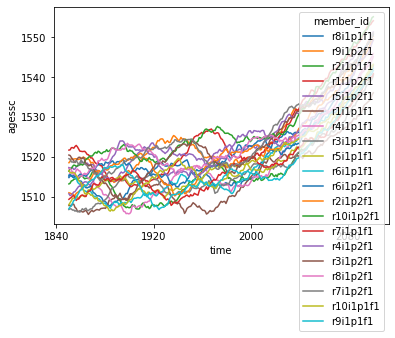

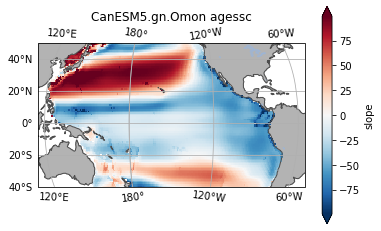

IPSL-CM6A-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


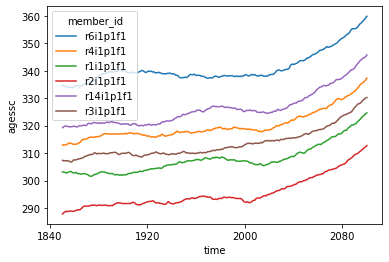

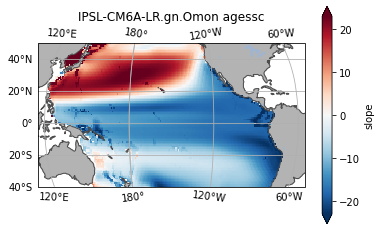

MIROC-ES2L.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


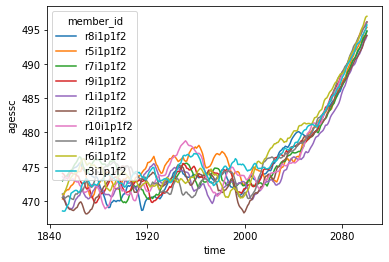

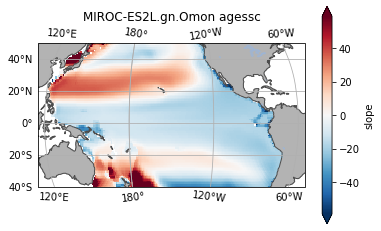

MPI-ESM1-2-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


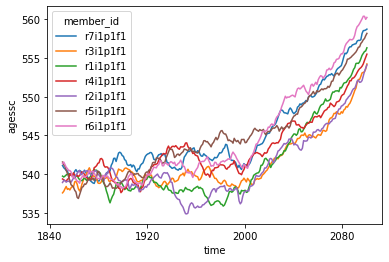

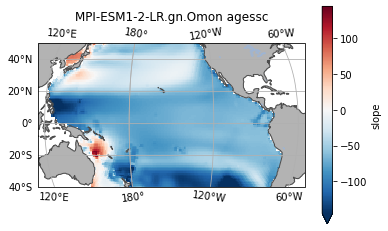

ACCESS-ESM1-5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


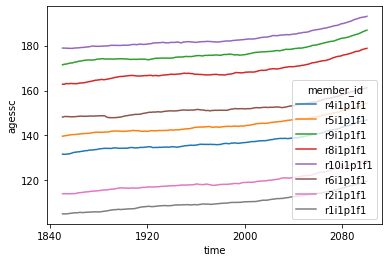

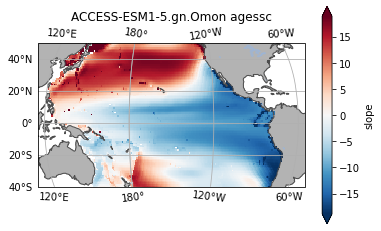

GFDL-CM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_

refactor to polish_map?


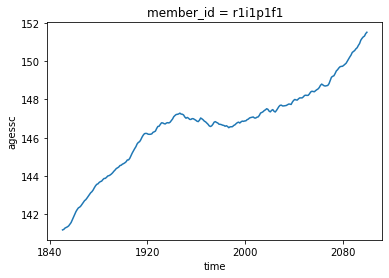

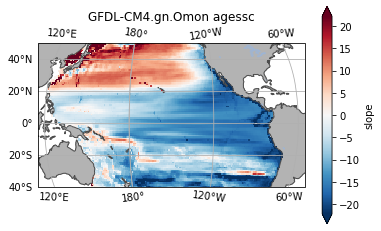

CanESM5-CanOE.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


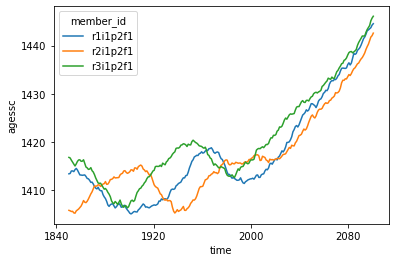

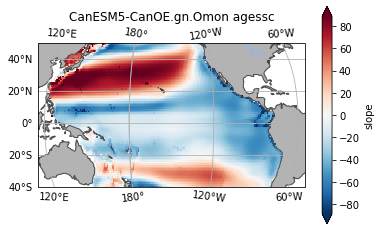

NorESM2-MM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


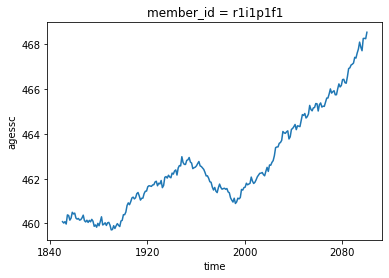

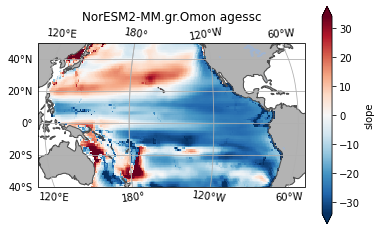

GFDL-ESM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


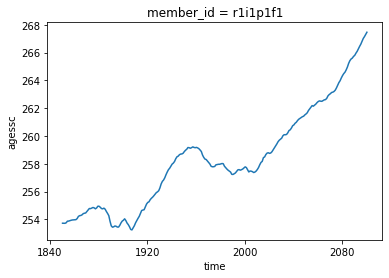

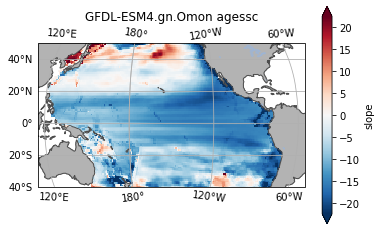

NorESM2-LM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


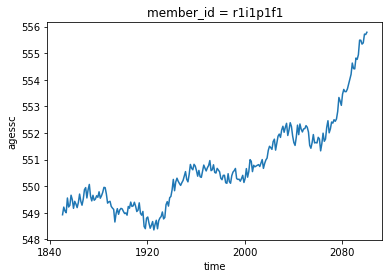

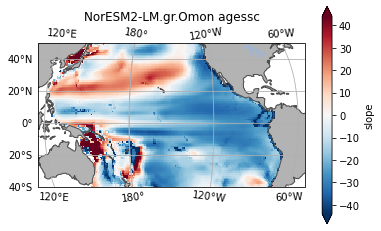

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


CanESM5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


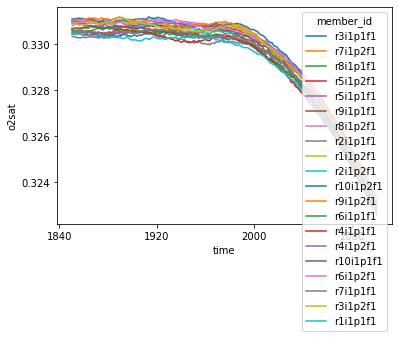

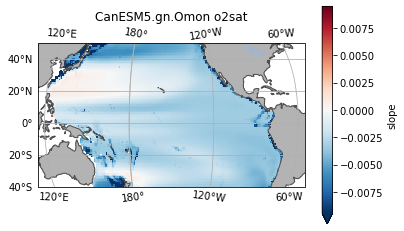

MPI-ESM1-2-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


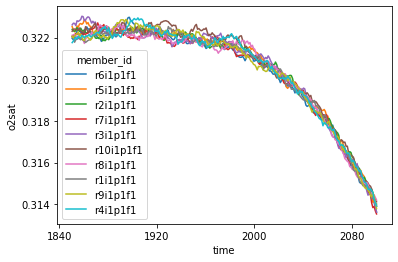

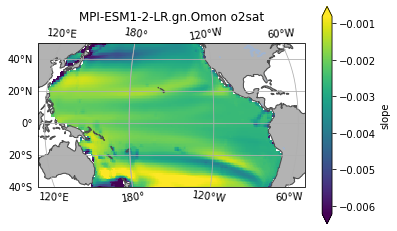

MIROC-ES2L.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


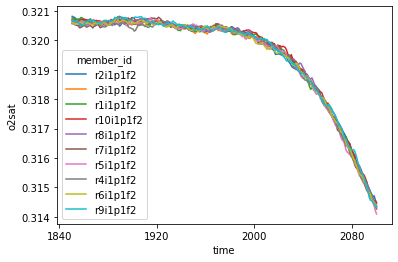

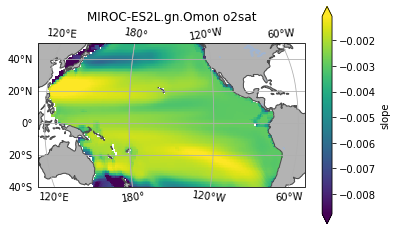

ACCESS-ESM1-5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


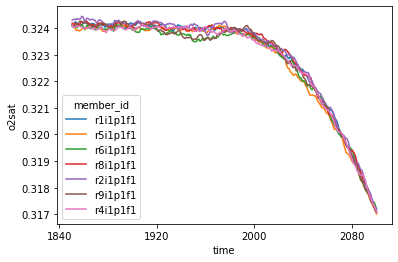

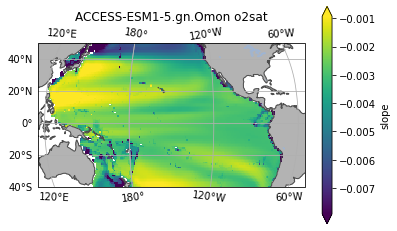

CNRM-ESM2-1.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


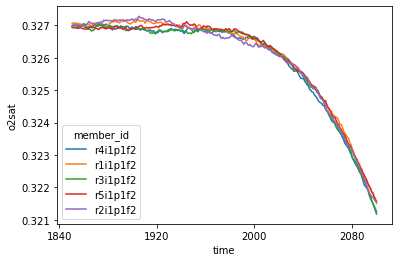

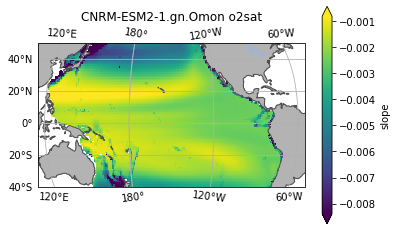

NorESM2-LM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


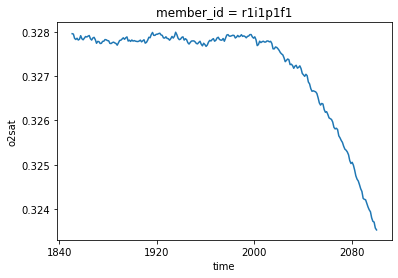

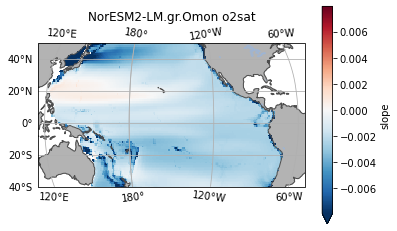

GFDL-ESM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


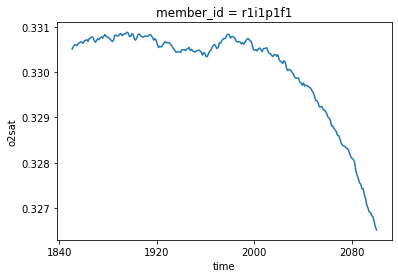

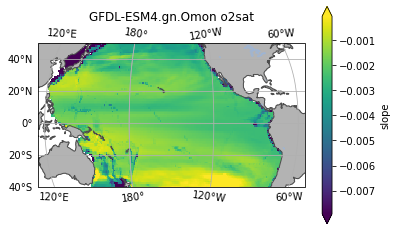

IPSL-CM6A-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


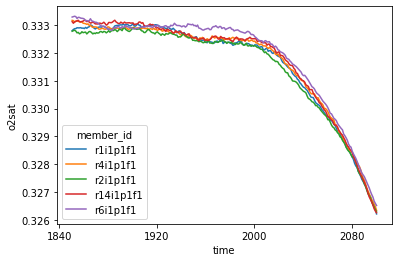

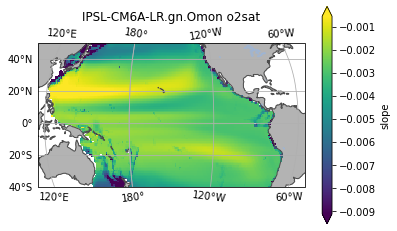

CanESM5-CanOE.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


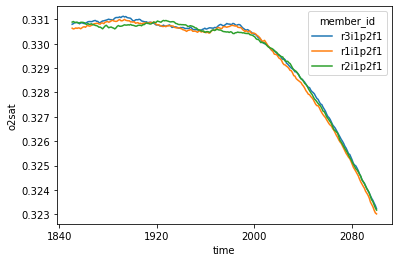

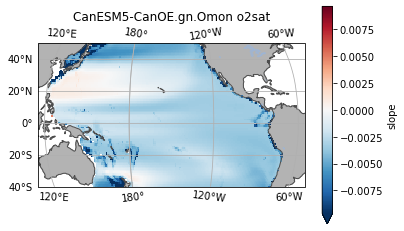

UKESM1-0-LL.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


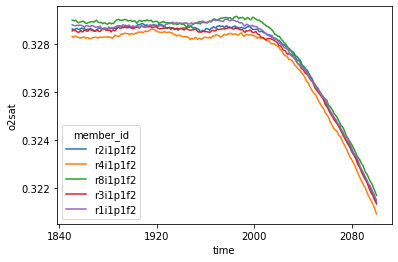

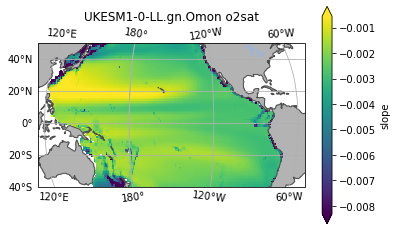

MRI-ESM2-0.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


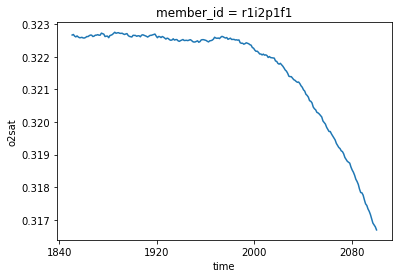

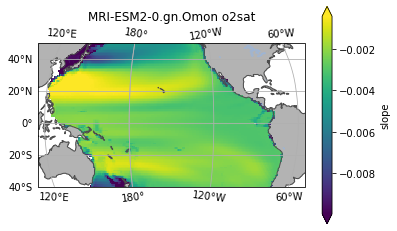

NorESM2-MM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


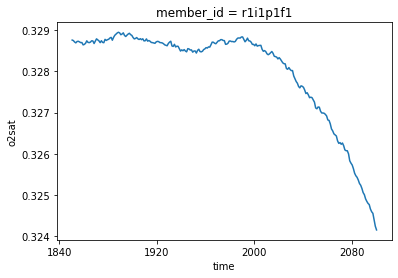

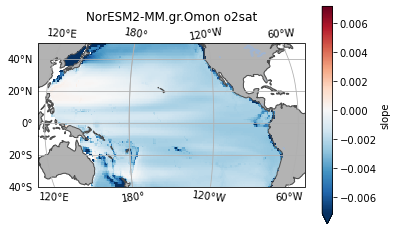

MPI-ESM1-2-HR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


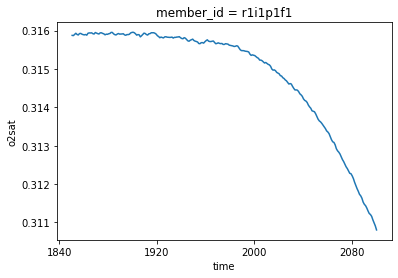

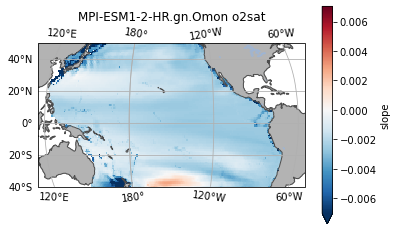

GFDL-CM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


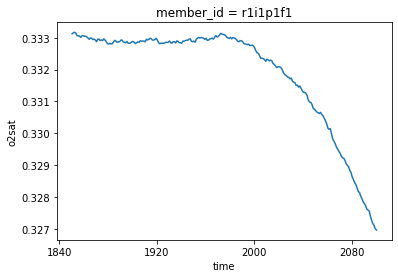

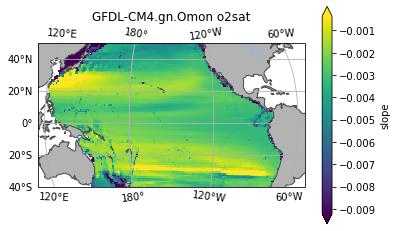

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


CNRM-ESM2-1.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


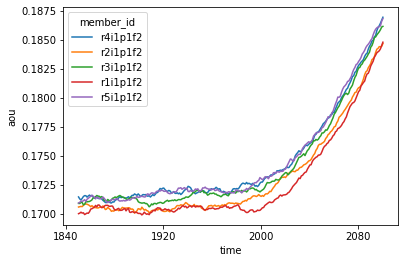

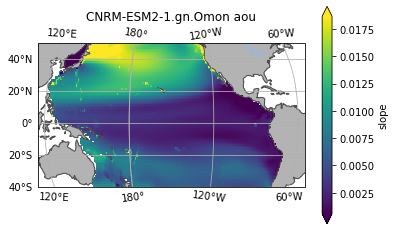

ACCESS-ESM1-5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


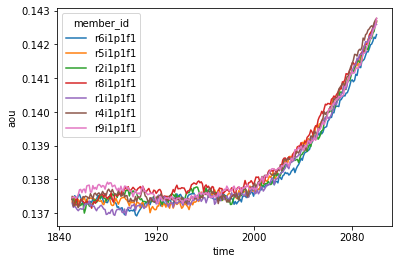

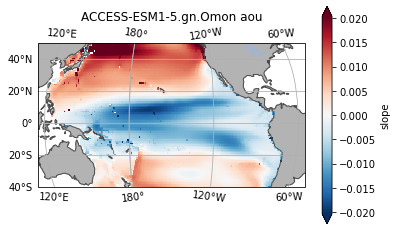

CanESM5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


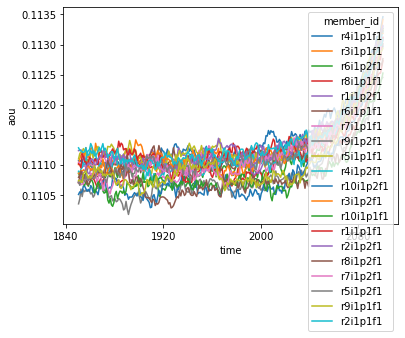

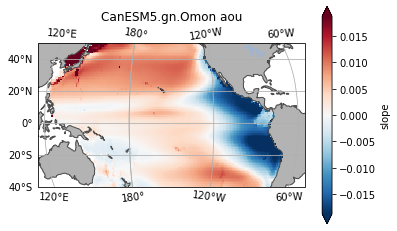

UKESM1-0-LL.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


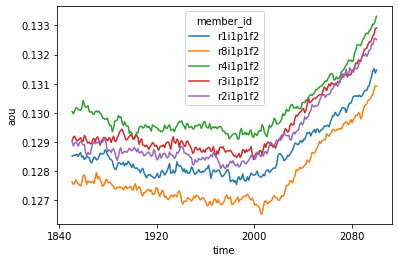

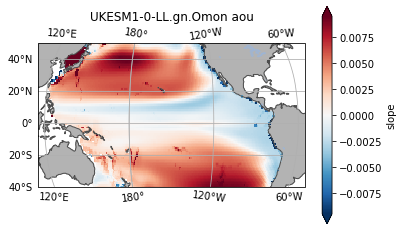

MPI-ESM1-2-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


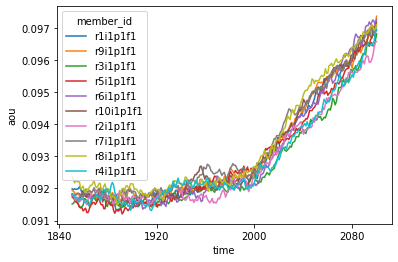

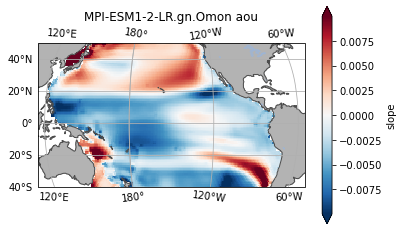

CanESM5-CanOE.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


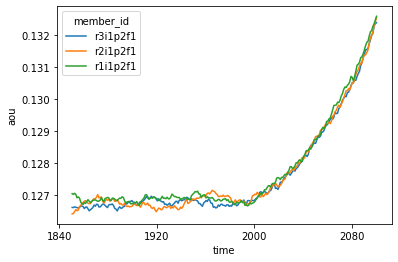

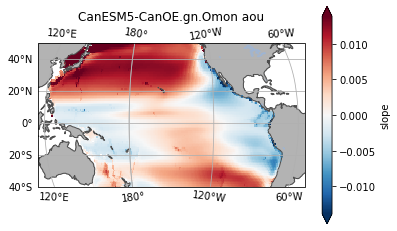

NorESM2-MM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


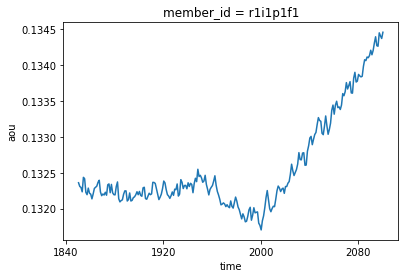

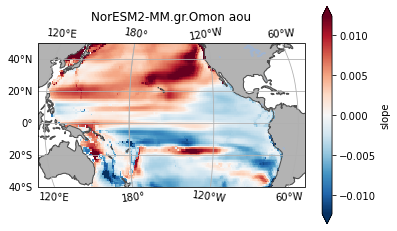

MIROC-ES2L.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


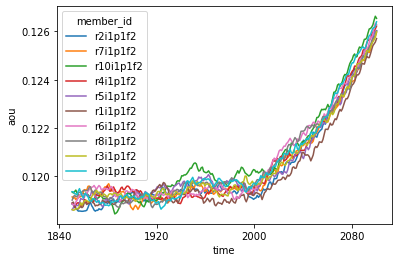

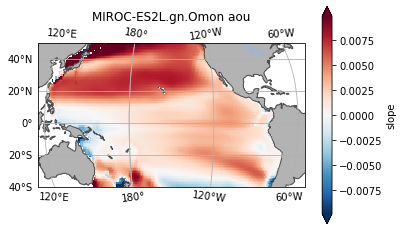

MRI-ESM2-0.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


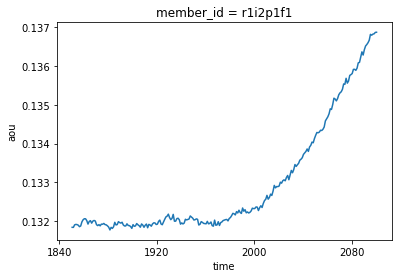

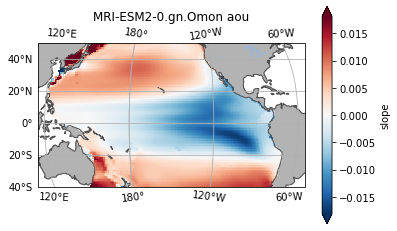

IPSL-CM6A-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


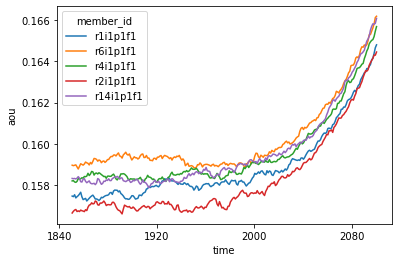

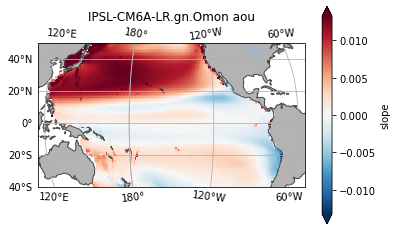

MPI-ESM1-2-HR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


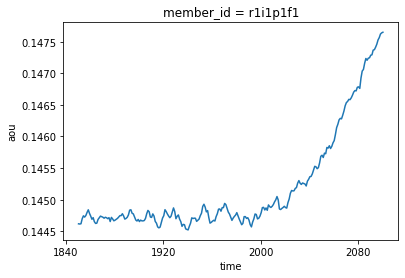

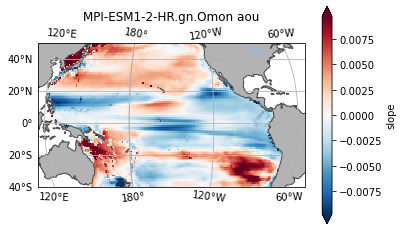

NorESM2-LM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


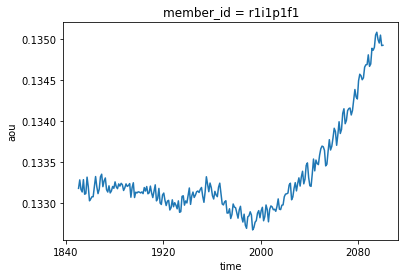

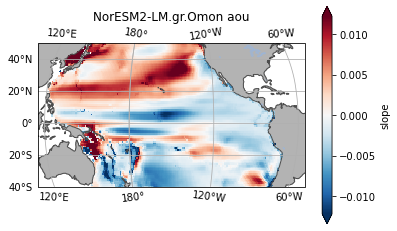

GFDL-CM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


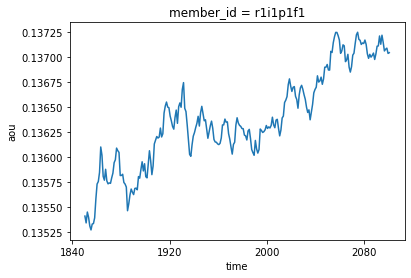

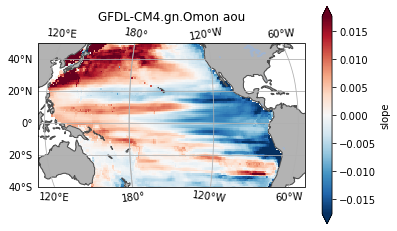

GFDL-ESM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


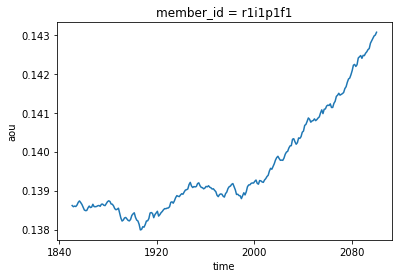

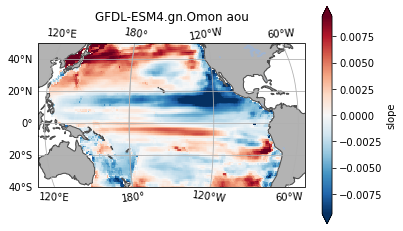

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


ACCESS-ESM1-5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


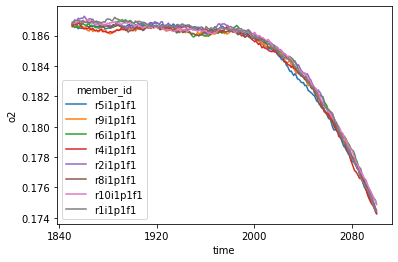

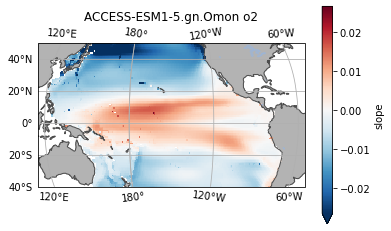

MPI-ESM1-2-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


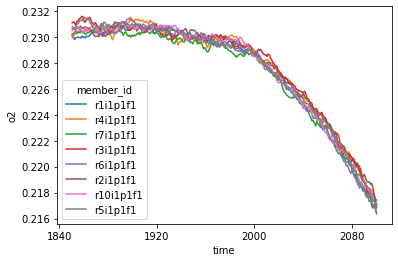

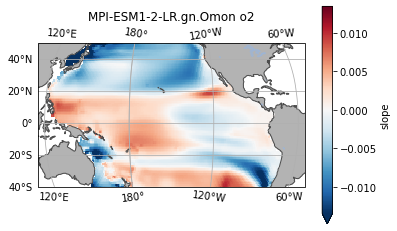

MIROC-ES2L.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


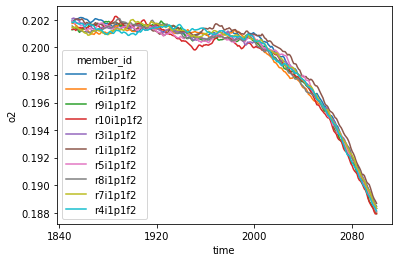

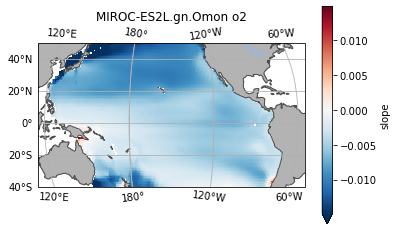

CNRM-ESM2-1.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


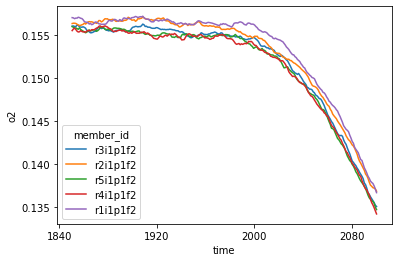

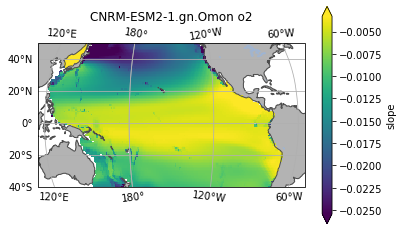

CanESM5.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


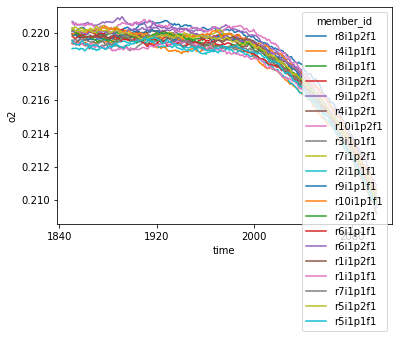

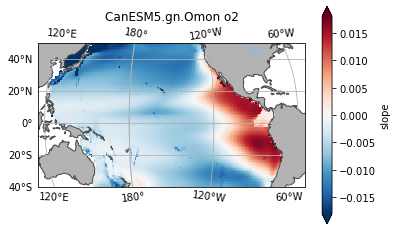

GFDL-ESM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


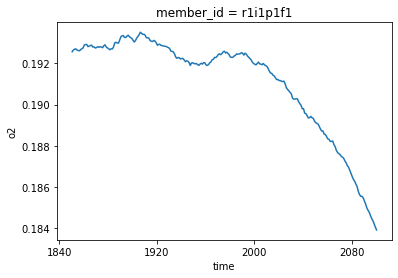

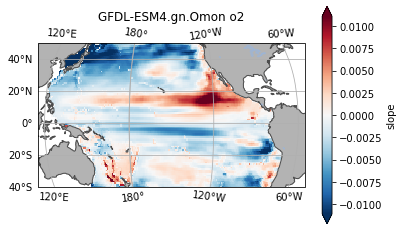

IPSL-CM6A-LR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


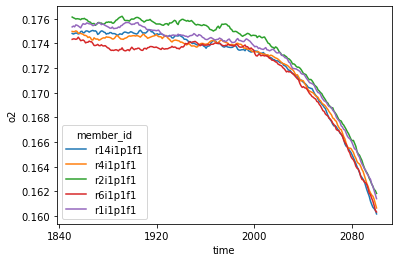

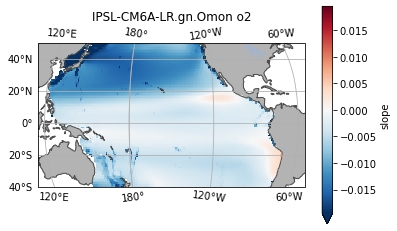

MPI-ESM1-2-HR.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


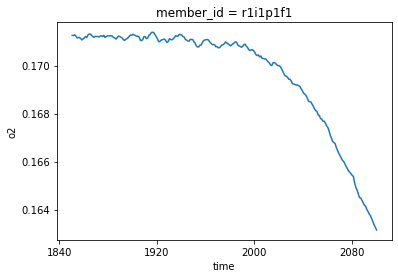

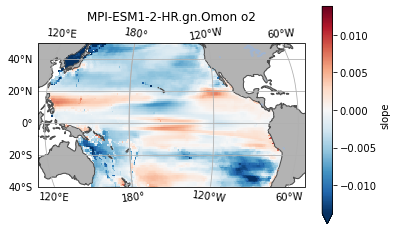

CanESM5-CanOE.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


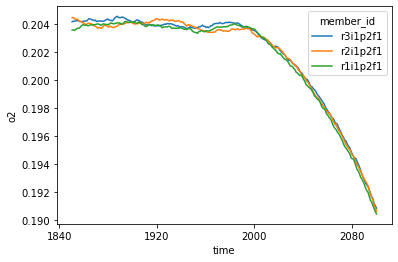

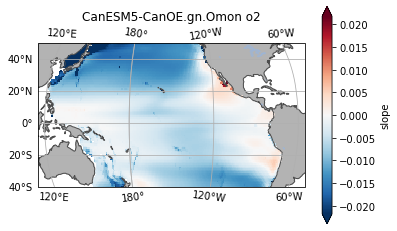

UKESM1-0-LL.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


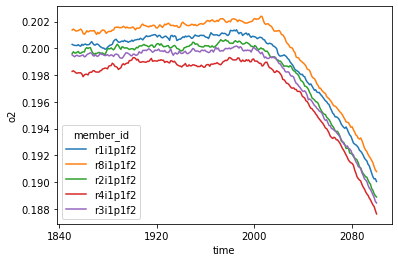

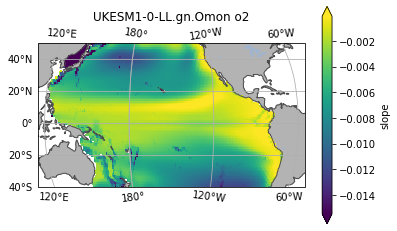

MRI-ESM2-0.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


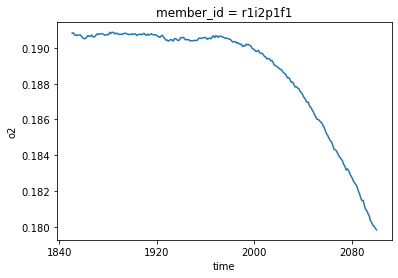

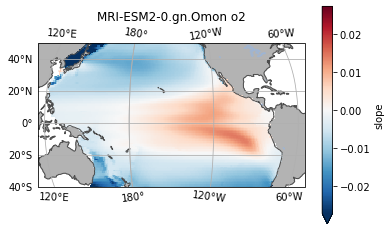

GFDL-CM4.gn.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


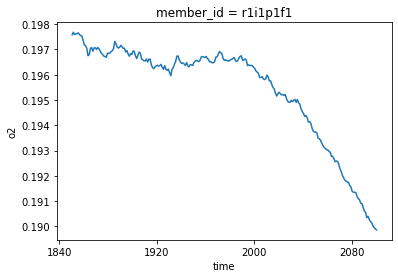

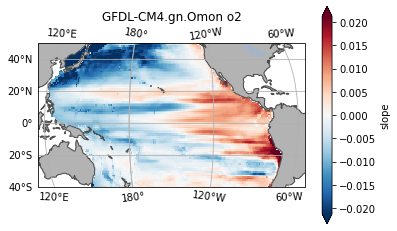

NorESM2-MM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


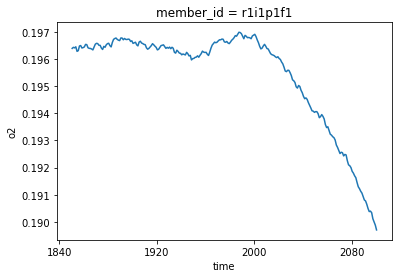

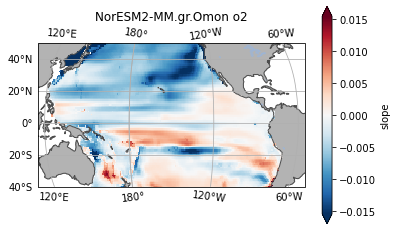

NorESM2-LM.gr.Omon


/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


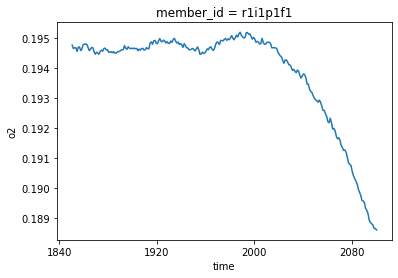

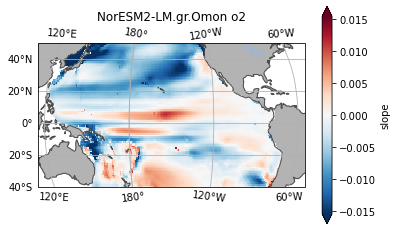

In [17]:
# temp version for o2sat and aou (currently only one member per model) TODO: I think this is outdated.
# Check with the tracked members

# version for all o2 models (no matter of age).

depth_pattern = '100-3000m'
path = '/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/cmip6_depth_average_v0.3/'
# path = '/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/cmip6_depth_average_v0.4/' TODO delete this


for var in ['agessc','o2sat', 'aou', 'o2']:

    average_ddict = load_zarr_directory(path, pattern=f'*{depth_pattern}_{var}.zarr')
    
    # some special checks:
    average_ddict = {k:ds for k,ds in average_ddict.items() if len(ds.time) >= 251}
    if var == 'agessc':
        average_ddict = {k:ds for k,ds in average_ddict.items() if not fail_age(ds)}

    track_members[var] = {}

    # There is one wrongly saved file for CM4 (TODO resave that without variable id)
    # for now...
    def _del_attr(ds, attr):
        if attr in ds.attrs.keys():
            del ds.attrs[attr]
        return ds
    average_ddict = {k:_del_attr(ds, 'variable_id') for k, ds in average_ddict.items()}
    average_ddict = concat_members(average_ddict,concat_kwargs={
        'combine_attrs': 'drop_conflicts',
        'compat':'override',
        'coords':'minimal',
    })

    datasets = []

    for k in average_ddict.keys():
        print(k)

        ds = average_ddict[k]

        source_id = ds.source_id
        ds = ds.sel(time=slice('1850', '2100'))
        
        #     # ACCESS has member resolved lon/lat? Ill just overwrite that
        if 'member_id' in ds.lon.dims:
            ds.coords['lon'] = ds['lon'].isel(member_id=0).squeeze()
            ds.coords['lat'] = ds['lat'].isel(member_id=0).squeeze()


        plt.figure()
        ds[var].mean(['x','y']).plot(hue='member_id')

        ds, n_member, member_ids = member_treatment(ds)
        track_members[var][k] = member_ids

        plt.figure()
        try:
            var_slope, _ = slope(ds[var])

            var_slope = regrid(var_slope).load()
            var_slope = mask_basin(var_slope)
            var_slope = var_slope.where(abs(var_slope.lat)<50)

            var_slope.plot(robust=True, subplot_kws=dict(projection=projection), **map_kwargs)

            finish_map_plot(plt.gca())
            plt.title(f"{k} {var}")
            plt.show()

            var_slope = var_slope.assign_coords(n_members = xr.DataArray(n_member, coords={'model':source_id}))

            datasets.append(var_slope)
        except Exception as e:
            print(f'failed for {k} with {e}')

    ds_combo = xr.concat(datasets, 'model')

    ds_combo.to_dataset(name=var).to_zarr(ifolder.joinpath(f"combined_{var}_{depth_pattern}.zarr"), mode='w')

## Same for export

TODO: Homogenize with other processing for final version

In [18]:
path = '/tigress/GEOCLIM/LRGROUP/samjd/global_omz/cmip6_omz/data/external/epc_processed_files2'
flist = list(pathlib.Path(path).glob('*.nc'))
ddict_epc = {f.stem:xr.open_dataset(str(f), chunks={'time':1}) for f in flist}
track_members_epc = {}

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


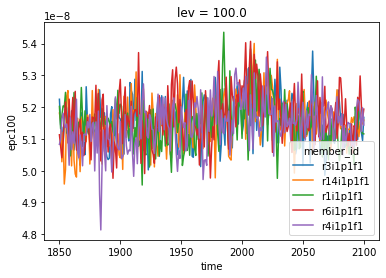

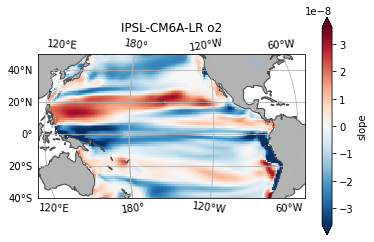

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


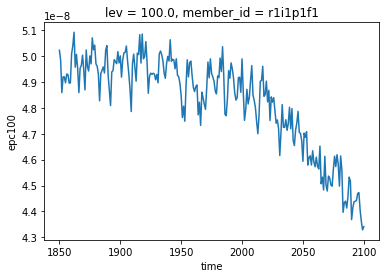

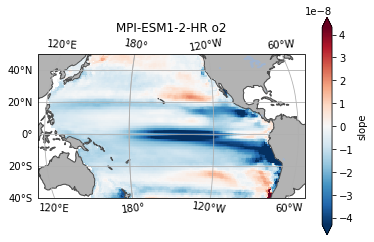

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


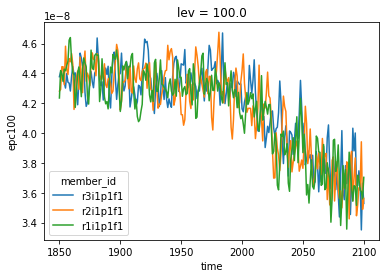

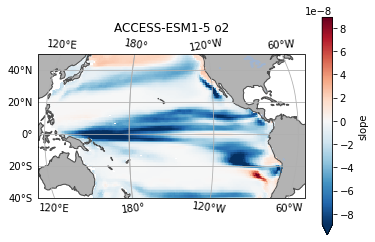

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


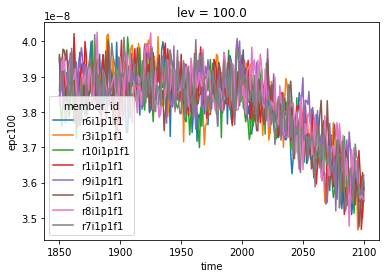

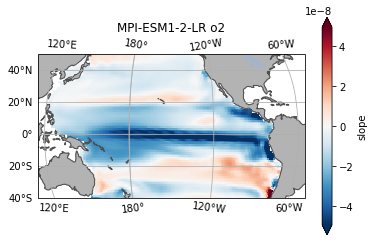

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


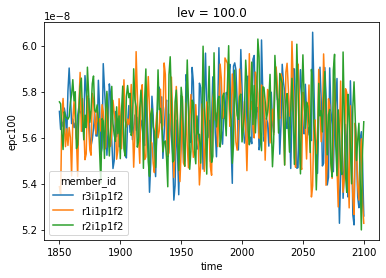

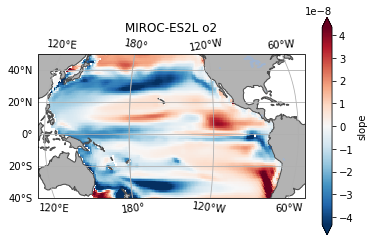

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


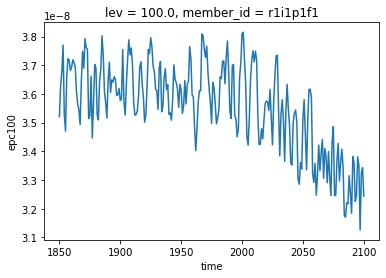

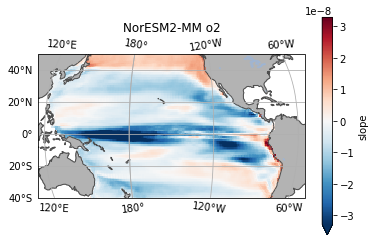

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


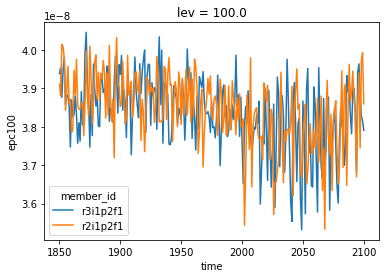

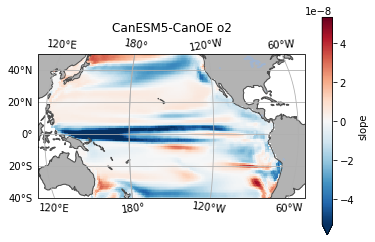

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


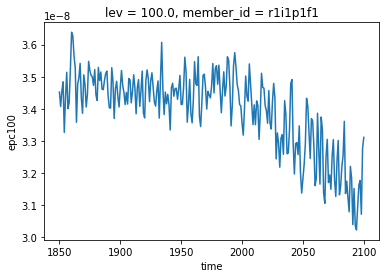

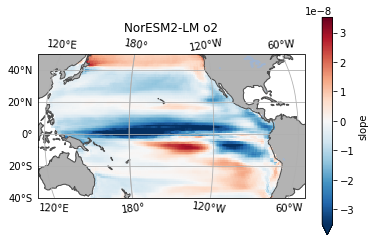

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


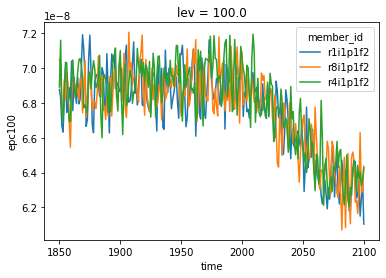

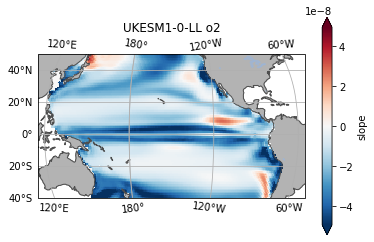

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/smm.

refactor to polish_map?


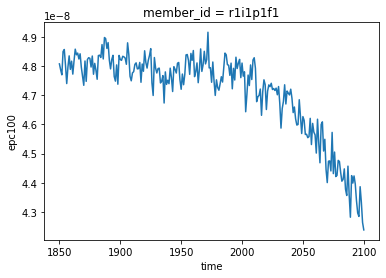

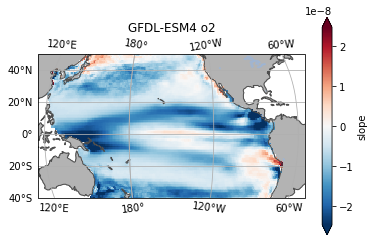

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


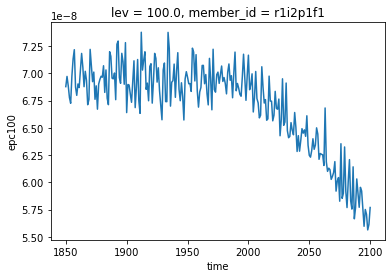

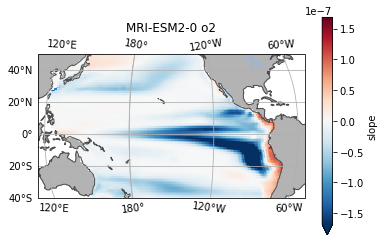

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


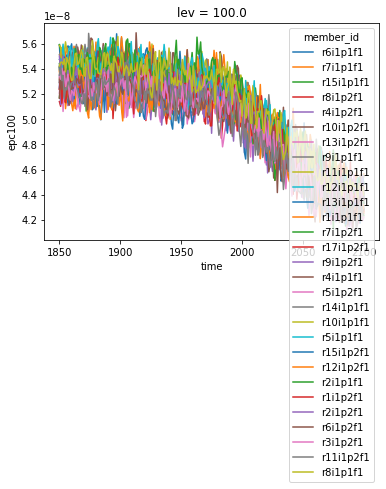

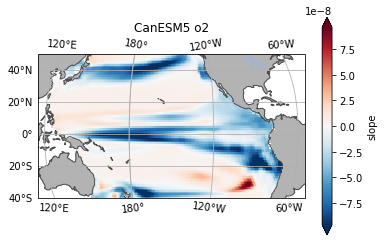

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


refactor to polish_map?


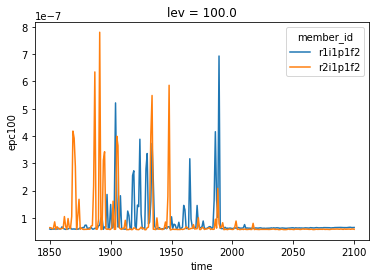

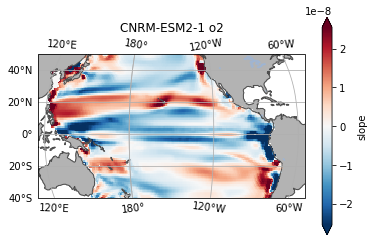

In [19]:
datasets_epc100 = []
for k,ds in ddict_epc.items():
    source_id = ds.source_id
    ds = ds.sel(time=slice('1850', '2100'))
    da = ds.epc100

#     da, _ = slope(ds.epc100)
#     da

    plt.figure()
    da.mean(['x','y']).plot(hue='member_id')

    da, n_members, member_ids = member_treatment(da)
    track_members_epc[k]=member_ids

    
    try:
        var_slope, _ = slope(da)

        var_slope = regrid(var_slope).load()
        var_slope = mask_basin(var_slope)
        var_slope = var_slope.where(abs(var_slope.lat)<50)
        
        plt.figure()
        var_slope.plot(robust=True, subplot_kws=dict(projection=projection), **map_kwargs)
        finish_map_plot(plt.gca())
        plt.title(f"{k} {var}")
        plt.show()

        var_slope = var_slope.assign_coords(n_members = xr.DataArray(n_member, coords={'model':source_id}))

        datasets_epc100.append(var_slope)
    except Exception as e:
        print(f'failed for {k} with {e}')

ds_combo_epc100 = xr.concat(datasets_epc100, 'model', coords='minimal')

for prefix, ds in [('epc100', ds_combo_epc100)]:
    ds.to_dataset(name=prefix).to_zarr(ifolder.joinpath(f"combined_{prefix}_{depth_pattern}.zarr"), mode='w')

## Precompute historical average and trend for selected surfaces

In [20]:
# Boundary data
# path = '/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/oxycline/v1.0/'
path = '/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/oxycline/v2.0/'
ddict_temp = load_zarr_directory(path, pattern='*omz_boundary.zarr')
ddict_omz_boundary = concat_members(
    {
        cmip6_dataset_id(ds):cut_long_members(ds) for ds in ddict_temp.values() if len(cut_long_members(ds).time)==251
    }
)
ddict_omz_boundary['obs_bianchi'] = xr.open_zarr(path+'/obs.zarr')
assert len(ddict_omz_boundary) == 15 # make sure all models are there...

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['experiment_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


In [21]:
overwrite=True
datasets_pp = {}
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for name, ds_raw in ddict_omz_boundary.items():
        attrs = {k:v for k,v in ds_raw.attrs.items()}
        filename = ifolder.joinpath(f"regridded_v0.1/{cmip6_dataset_id(ds_raw)}")
        print(name)
        if (not zarr_exists(filename)) or overwrite:
            # eliminate long runs
            if 'time' in ds_raw.dims:
                ds = cut_long_members(ds_raw)
            else:
                ds = ds_raw

            # only take a few thresholds
            ds = ds.sel(o2_threshold=[core_o2,center_o2, outer_o2])

            # add thickness
            ds["thickness"] = (
                ds.lower_boundary - ds.upper_boundary
            )
            # mask out data appropriately for each threshold 
            # (TODO: this should be done in the original algo)
            mask_datasets = [
                make_mask(ds, t, var='o2_min_value').assign_coords(o2_threshold=t)
                for t in ds.o2_threshold.data
            ]
            mask = xr.concat(mask_datasets, "o2_threshold")
            ds = ds.where(mask)

            # create new dataset
            ds_out = xr.Dataset()


            # compute trends
            for var in ['thickness', 'upper_boundary', 'lower_boundary']:
                if 'time' in ds.dims:
                    ds_out['trend_'+var] = linear_trend(ds[var], "time").slope * 100
                    ds_out['historical_'+var] = ds[var].sel(time=hist_slice).mean("time")
                else:
                    ds_out['trend_'+var] = xr.ones_like(ds[var])*np.nan
                    ds_out['historical_'+var] = ds[var]

            # add historical minimum o2
            if 'time' in ds.dims:
                ds_out['historical_o2_min_value'] = ds_raw['o2_min_value'].sel(time=hist_slice).mean('time')
            else:
                ds_out['historical_o2_min_value'] = ds_raw['o2_min_value']
                
            with ProgressBar():
                for va in ds_out.data_vars:
                    print(va)
                    ds_out[va] = ds_out[va].load()
#                 ds_out = ds_out.load()
            ds_out = regrid(ds_out)
            ds_out = ds_out.chunk({"x": -1})
            ds_out.to_zarr(filename, consolidated=True, mode="w")
            ds_out.attrs = attrs
        else:
            print('exists')
        ds_reloaded = xr.open_zarr(
                filename, consolidated=True, use_cftime=True
        ).load()
    
        # quick_fix for a faulty IPSL member
        # TODO: remove and check the raw file (do that for all models actually!)
        if 'IPSL' in attrs.get('source_id', 'none'):
            if 'r3i1p1f1' in ds_reloaded.member_id.data:
                ds_reloaded = ds_reloaded.drop_sel(member_id='r3i1p1f1')
            
        
        ds_reloaded = ds_reloaded.assign_coords(model=attrs.get('source_id', 'obs_bianchi'))
        ds_reloaded = ds_reloaded.expand_dims('model') # TODO should be done above

        datasets_pp[cmip6_dataset_id(ds_raw)] = ds_reloaded


track_members_boundary = {}
for k, ds in datasets_pp.items():
    ds, averaged_members, member_ids = member_treatment(ds)
    ds = ds.assign_coords(
        averaged_members=xr.DataArray(
            [averaged_members],
            dims=ds.model.dims,
            coords=ds.model.coords
        ))
    track_members_boundary[k.split('.')[2]] = member_ids
    datasets_pp[k] = ds

ds_boundary_combined = xr.concat(
    datasets_pp.values(), "model", compat="override", coords="minimal", join="inner"
)
ds_boundary_combined = ds_boundary_combined.sortby('model')
ds_boundary_combined.to_zarr(ifolder.joinpath('boundary_combined.zarr'), mode='w')
ds_boundary_combined

UKESM1-0-LL.gn.Omon.o2
trend_thickness
[########################################] | 100% Completed | 39.3s
historical_thickness
[########################################] | 100% Completed |  4.4s
trend_upper_boundary
[########################################] | 100% Completed | 27.3s
historical_upper_boundary
[########################################] | 100% Completed |  4.0s
trend_lower_boundary
[########################################] | 100% Completed | 28.1s
historical_lower_boundary
[########################################] | 100% Completed |  4.2s
historical_o2_min_value
[########################################] | 100% Completed |  0.4s
CNRM-ESM2-1.gn.Omon.o2
trend_thickness
[########################################] | 100% Completed | 43.0s
historical_thickness
[########################################] | 100% Completed |  4.0s
trend_upper_boundary
[########################################] | 100% Completed | 27.5s
historical_upper_boundary
[##################################

[########################################] | 100% Completed |  0.7s
trend_lower_boundary
[########################################] | 100% Completed |  5.6s
historical_lower_boundary
[########################################] | 100% Completed |  0.7s
historical_o2_min_value
[########################################] | 100% Completed |  0.1s
GFDL-ESM4.gr.Omon.o2
trend_thickness
[########################################] | 100% Completed |  6.4s
historical_thickness
[########################################] | 100% Completed |  0.7s
trend_upper_boundary
[########################################] | 100% Completed |  4.5s
historical_upper_boundary
[########################################] | 100% Completed |  0.7s
trend_lower_boundary
[########################################] | 100% Completed |  4.9s
historical_lower_boundary
[########################################] | 100% Completed |  0.7s
historical_o2_min_value
[########################################] | 100% Completed |  0.1s
obs_b

<xarray.Dataset>
Dimensions:                    (model: 15, o2_threshold: 3, y: 180, x: 360)
Coordinates:
    lat                        (y, x) float64 -89.5 -89.5 -89.5 ... 89.5 89.5
    lon                        (y, x) float64 -179.5 -178.5 ... 178.5 179.5
  * o2_threshold               (o2_threshold) int64 20 60 120
  * model                      (model) <U13 'ACCESS-ESM1-5' ... 'obs_bianchi'
    averaged_members           (model) int64 9 5 20 3 1 1 5 10 1 10 1 1 1 5 1
Dimensions without coordinates: y, x
Data variables:
    historical_lower_boundary  (model, o2_threshold, y, x) float64 nan ... nan
    historical_o2_min_value    (model, y, x) float64 1e+32 1e+32 ... 0.2954
    historical_thickness       (model, o2_threshold, y, x) float64 nan ... nan
    historical_upper_boundary  (model, o2_threshold, y, x) float64 nan ... nan
    trend_lower_boundary       (model, o2_threshold, y, x) float64 nan ... nan
    trend_thickness            (model, o2_threshold, y, x) float64 nan ... nan
    trend_upper_boundary       (model, o2_threshold, y, x) float64 nan ... nan

## TODO: Add the full 3d change calculation preprocessing here

In [75]:
from xarrayutils.file_handling import write

def save_and_reload_for_plotting(ds, name, ofolder, tempfolder, **kwargs):
    filename = f"{name}_{cmip6_dataset_id(ds)}.zarr"
#     filename = f"{name}_{cmip6_dataset_id(ds)}.nc"
    filepath = ofolder.joinpath(filename)
    if zarr_exists(filepath):
        print('File exists already.')
        ds_out = xr.open_zarr(filepath)
    else:
        print(cmip6_dataset_id(ds))
        print('Rechunking and reloading for easier processing')
        with ProgressBar():
            temp_store = tempfolder.joinpath('rechunked.zarr')
            temp_temp_store = tempfolder.joinpath('rechunked_temp.zarr')
            ds = rechunk_to_temp(
                ds,
                temp_store,
                temp_temp_store,
                consolidated=True,
                overwrite=True,
                mem='512MiB'
            )
            print('Compute mean and trend')
            ds_historical = ds.sel(time=hist_slice).mean('time').load()
            ds_future = ds.sel(time=trend_slice)
            ds_trend = xr.Dataset()
            for v in ds.data_vars:
                change, p = slope(ds_future[v])
                ds_trend[v] = change.load()
            
            print('Wrap up')

            ds_new = xr.concat([ds_historical, ds_trend], dim='time')
            # convert to mmol/m^3, can do the other conversion later
            for var in ds_new.data_vars:
                if var not in ['agessc']:
                    ds_new[var] = ds_new[var] / 1035 *1e6
            ds_new = regrid(ds_new)
            ds_new = mask_basin(ds_new)
            ds_new.attrs = ds.attrs
            
            ds_out = write(ds_new, filepath, **kwargs)
    return ds_out

In [76]:
path = '/projects/GEOCLIM/LRGROUP/jbusecke/projects_data/full_o2_sat_v0.2/'
# idir = pathlib.Path('/projects/GEOCLIM/LRGROUP/jbusecke/projects/busecke_etal_2021_aguadv/data/interim/Revision_Plots_2.8/')
# TODO redo properly overnight
idir = pathlib.Path('/projects/GEOCLIM/LRGROUP/jbusecke/projects/busecke_etal_2021_aguadv/data/interim/Revision_Plots_2.7/')
tdir = idir.joinpath('temp')

ddict_full3d = load_zarr_directory(path, pattern='*.zarr')
ddict_full3d = {k:cut_long_members(ds) for k,ds in ddict_full3d.items()}
    
# replace fail age with nans (need to account for this later)
print('Eliminating invalid agessc for:')
for k,ds in ddict_full3d.items():
    if fail_age(ds):
        print(k)
        ddict_full3d[k]['agessc'] = xr.ones_like(ddict_full3d[k]['agessc']) * np.nan
        

print('Save out regridded trends')        
ddict_full3d_processed = {}
for i,(k,ds) in enumerate(ddict_full3d.items()):
    print(f"{i}/{len(ddict_full3d)}")
    ddict_full3d_processed[k] = save_and_reload_for_plotting(ds, 'hist_fut_averages',idir, tdir, overwrite=False).load()
    
# TODO: Remove if fully reprocessed
ddict_full3d_processed = {k:regrid(ds) for k,ds in ddict_full3d_processed.items()}
    
ddict_full3d_final = concat_members(
    ddict_full3d_processed,
    concat_kwargs={'combine_attrs': 'drop_conflicts', 'coords':'minimal'}
)

Save out regridded trends
0/72
File exists already.
1/72
File exists already.
2/72
File exists already.
3/72
File exists already.
4/72
File exists already.
5/72
File exists already.
6/72
File exists already.
7/72
File exists already.
8/72
File exists already.
9/72
File exists already.
10/72
File exists already.
11/72
File exists already.
12/72
File exists already.
13/72
File exists already.
14/72
File exists already.
15/72
File exists already.
16/72
File exists already.
17/72
File exists already.
18/72
File exists already.
19/72
File exists already.
20/72
File exists already.
21/72
File exists already.
22/72
File exists already.
23/72
File exists already.
24/72
File exists already.
25/72
File exists already.
26/72
File exists already.
27/72
File exists already.
28/72
File exists already.
29/72
File exists already.
30/72
File exists already.
31/72
File exists already.
32/72
File exists already.
33/72
File exists already.
34/72
File exists already.
35/72
File exists already.
36/72
File e

/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/home/jbusecke/code/miniconda/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:113: UserWarning: Match attributes ['grid_label', 'experiment_id', 'variable_id'] not found in any of the datasets.         This can happen when several combination functions are used.
  warnings.warn(


In [81]:
# concat to one main dataset
datasets = []
models = []

# Make suer we have all models
assert len(ddict_full3d_final) == 14

# TODO: replace with old logic again...
ref_lev = ddict_full3d_final['IPSL-CM6A-LR.Omon'].lev
# ref_lev = ddict_full3d_final['IPSL-CM6A-LR.gn.Omon'].lev

for i,(k,ds) in enumerate(ddict_full3d_final.items()):
    print(f"{i} {k}")
    attrs = {k:v for k,v in ds.attrs.items() if k!='grid_label'}
    attrs['n_members'] = len(ds.member_id)
    
    ds_out = ds.mean('member_id').interp(lev=ref_lev).drop([v for v in ['dz_t'] if v in ds])
#     sign_coords = sign_agreement(ds)
    # add nans for age if not present
    if 'agessc' not in ds_out:
        print(f"Filling dummy age for {attrs['source_id']}")
        ds_out['agessc'] = xr.ones_like(ds_out.o2) * np.nan
    ds_out.attrs = attrs
    datasets.append(ds_out)
    models.append(ds_out.source_id)
    
ds_main = xr.concat(datasets, dim=xr.DataArray(models, dims=['source_id'], name='source_id'), join='exact')

0 CanESM5.Omon
1 MIROC-ES2L.Omon
2 MPI-ESM1-2-LR.Omon
3 UKESM1-0-LL.Omon
Filling dummy age for UKESM1-0-LL
4 CanESM5-CanOE.Omon
5 MRI-ESM2-0.Omon
6 NorESM2-LM.Omon
7 MPI-ESM1-2-HR.Omon
8 IPSL-CM6A-LR.Omon
9 ACCESS-ESM1-5.Omon
10 GFDL-ESM4.Omon
11 CNRM-ESM2-1.Omon
Filling dummy age for CNRM-ESM2-1
12 NorESM2-MM.Omon
13 GFDL-CM4.Omon


In [85]:
ds_main.to_netcdf(ifolder.joinpath('full_3d_changes_combined.nc'), mode='w')

In [86]:
xr.open_dataset(ifolder.joinpath('full_3d_changes_combined.nc'))

<xarray.Dataset>
Dimensions:    (source_id: 14, time: 2, lev: 75, y: 240, x: 260)
Coordinates:
    lon        (y, x) int64 ...
    lat        (y, x) float64 ...
  * x          (x) int64 50 51 52 53 54 55 56 57 ... 303 304 305 306 307 308 309
  * y          (y) float64 -60.0 -59.5 -59.0 -58.5 -58.0 ... 58.0 58.5 59.0 59.5
  * lev        (lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * source_id  (source_id) object 'CanESM5' 'MIROC-ES2L' ... 'GFDL-CM4'
Dimensions without coordinates: time
Data variables:
    agessc     (source_id, time, lev, y, x) float64 ...
    aou        (source_id, time, lev, y, x) float64 ...
    o2         (source_id, time, lev, y, x) float64 ...
    o2sat      (source_id, time, lev, y, x) float64 ...
Attributes: (12/32)
    CCCma_model_hash:      Unknown
    Conventions:           CF-1.7 CMIP-6.2
    branch_method:         Spin-up documentation
    cmor_version:          3.4.0
    contact:               ec.cccma.info-info.ccmac.ec@canada.ca
    data_specs_version:    01.00.29
    ...                    ...
    sub_experiment_id:     none
    table_id:              Omon
    table_info:            Creation Date:(20 February 2019) MD5:374fbe5a2bcca...
    title:                 CanESM5 output prepared for CMIP6
    version:               v20190429
    n_members:             20

In [84]:
str(ifolder.joinpath('full_3d_changes_combined.nc')) == '/projects/GEOCLIM/LRGROUP/jbusecke/projects/busecke_etal_2021_aguadv/data/processed_revision_2.2/full_3d_changes_combined.nc'

True

In [82]:
ds_main

<xarray.Dataset>
Dimensions:    (source_id: 14, time: 2, lev: 75, y: 240, x: 260)
Coordinates:
    lon        (y, x) int64 50 51 52 53 54 55 56 ... 303 304 305 306 307 308 309
    lat        (y, x) float64 -60.0 -60.0 -60.0 -60.0 ... 59.5 59.5 59.5 59.5
  * x          (x) int64 50 51 52 53 54 55 56 57 ... 303 304 305 306 307 308 309
  * y          (y) float64 -60.0 -59.5 -59.0 -58.5 -58.0 ... 58.0 58.5 59.0 59.5
  * lev        (lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * source_id  (source_id) <U13 'CanESM5' 'MIROC-ES2L' ... 'GFDL-CM4'
Dimensions without coordinates: time
Data variables:
    agessc     (source_id, time, lev, y, x) float64 nan nan nan ... nan nan nan
    aou        (source_id, time, lev, y, x) float64 nan nan nan ... nan nan nan
    o2         (source_id, time, lev, y, x) float64 nan nan nan ... nan nan nan
    o2sat      (source_id, time, lev, y, x) float64 nan nan nan ... nan nan nan
Attributes: (12/32)
    CCCma_model_hash:      Unknown
    Conventions:           CF-1.7 CMIP-6.2
    branch_method:         Spin-up documentation
    cmor_version:          3.4.0
    contact:               ec.cccma.info-info.ccmac.ec@canada.ca
    data_specs_version:    01.00.29
    ...                    ...
    sub_experiment_id:     none
    table_id:              Omon
    table_info:            Creation Date:(20 February 2019) MD5:374fbe5a2bcca...
    title:                 CanESM5 output prepared for CMIP6
    version:               v20190429
    n_members:             20

In [80]:
! rm {str(ifolder.joinpath('full_3d_changes_combined.nc'))}

## TODO: Check member_ids across different outputs

In [22]:
## Compare missing members
# TODO: Refactor this for final release
models = track_members_o2.keys()
for m in models:
    print('----------------')
    print(m)
    m_epc = m.split('.')[0]
    if m_epc not in track_members_epc.keys():
        print(f"{m_epc} not found in epc dict")
    else:
        epc_members = track_members_epc[m_epc]
    
        o2_members = track_members_o2[m]


        missed_members = set(epc_members).symmetric_difference(set(o2_members))
        if len(missed_members)==0:
            print(f"Export_dict: {m_epc} OK")
        else:
            print(f"Export_dict: {m_epc} didnt find {missed_members}")
    
    m_boundary = m_epc
    if m_boundary not in track_members_boundary.keys():
        print(f"{m_epc} not found in boundary dict")
    else:
        boundary_members = track_members_boundary[m_boundary]
    
        o2_members = track_members_o2[m]


        missed_members = set(boundary_members).symmetric_difference(set(o2_members))
        if len(missed_members)==0:
            print(f"Boundary_dict: {m_epc} OK")
        else:
            print(f"Boundary_dict: {m_epc} didnt find {missed_members}")
            print(set(o2_members))
            
    if m_boundary not in track_members_boundary.keys():
        print(f"{m_epc} not found in boundary dict")
    else:
        boundary_members = track_members_boundary[m_boundary]
    
        o2_members = track_members_o2[m]


        missed_members = set(boundary_members).symmetric_difference(set(o2_members))
        if len(missed_members)==0:
            print(f"Boundary_dict: {m_epc} OK")
        else:
            print(f"Boundary_dict: {m_epc} didnt find {missed_members}")
            print('o2',set(o2_members))

NameError: name 'track_members_o2' is not defined